<a href="https://colab.research.google.com/github/ifaul/ifaul.github.io/blob/main/lang_predict12_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ian Faul, Matthew Vuong

**Predicting native languages of adult English learners from proficiency test performance**

[Link to our website](https://ifaul.github.io/)

[Link to CSV file in Drive](https://drive.google.com/file/d/1LJg6wTE_rl3WXP5lOFRoCuatc1WZjEQm/view?usp=share_link)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

pd.options.mode.copy_on_write = True
np.random.seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks


In [3]:
#%%shell
#jupyter nbconvert --to html /content/drive/MyDrive/ColabNotebooks/lang_acquire_milestone1.ipynb

# **Project Goals**

How humans acquire new languages, and why some people are better at it than others, remains a remarkably mysterious question. While it is well-known that children are the most efficient language learners and that language-learning ability declines with age, the specific factors contributing to learning ability (age, gender, country of origin, native language, age at start of second language acquisition, etc.) are more complicated. Here, we plan on using a large dataset of close to 650,000 individuals to disentangle some of these factors. In particular, we are curious to see whether there are any patterns in performance on particular questions across various groups, which would reveal both the underlying linguistic features being tested and those that are compartively more difficult to acquire. This was something not examined by the study associated with this dataset (Hartshorne, J.K. et al, 2018); while our intention isn't to directly replicate their findings, our secondary goal is to determine whether our results converge with their conclusions.

**Collaboration plan**

We (Ian Faul and Matthew Vuong) plan on meeting weekly to discuss the project's direction and implementation, assisting each other when necessary. We will also regularly update a document tracking which steps need to be completed and who they are to be completed by to ensure that work is fairly distributed. Lastly, we will establish a shared Github respository to store our code and our updates to it, allowing us to work remotely.

# **Speakers dataset**
### **ETL**

We came across this dataset in the "Data Is Plural" archive and downloaded it from [OSF](https://osf.io/pyb8s/wiki/home/). We considered several similar datasets for this project, but this one stood out due to the large number of variables and observations, as well as its being associated with a study whose conclusions we could build on. The original dataset included the following variables:

**id** Unique subject ID

**date** Date at start of experiment

**time** Time at start of experiment

**gender**

**age**

**natlangs** List of subject's native languages

**primelangs** List of subject's primary language now

**dyslexia** Did subject report difficulty with reading?

**psychiatric** Did subject report any psychiatric disorders

**education** highest level of education

**Eng_start** age at start of English learning

**Eng_country_yrs** number of years living in English-speaking country

**house_Eng** subject lives with any native English speakers?

**dictionary** subject reported using a dictionary to complete experiment

**already_participated** Subject reported prior participation in experiment

**countries** countries lived in

**currcountry** country currently lived in

**US_region** regions of USA lived in

**UK_region** regions of UK lived in

**Can_region** regions of Canada lived in

**Ebonics** speaker of Ebonics?

**Ir_region** county of Ireland lived in

**UK_constituency** constituency of UK lived in

**nat_Eng** native speaker of English

**lived_Eng_per** Percentage of years speaking English that lived in English-speaking country.

**Eng_little** values are monoeng (native speaker of English only), bileng (native speaker of English + at least one other lang), lot (immersion learner), little (non-immersion learner).

**q1, q2, etc.** test questions, with subparts

**correct** percentage of critical items correct

**elogit** elogit of correct (not sure what this means)


While this data was originally collected for the primary purpose of finding the critical point in development where grammar-learning ability begins to decline (their finding: 17.4 years), some other specific questions this dataset allows us to consider are (1) Can the test questions be grouped into distinct types, other than the syntactic phenomena explicity included by the original researchers, based on systematic differences in performance among groups? (2) Are there systematic differences in the performance of speakers of native languages other than English? In other words, in which ways do speakers of some languages (or language groups) perform better or worse than others? (3) For people at or above the critical age found in the original study, which variables are associated with the highest overall performance or performance on specific questions/question types?

In the following section, we consider a more workable subset of 10,000 observations, removing variables likely of little relevance, creating new columns to more easily access information separated by commas in individual cells in the original data table, making values within columns consistent and of the correct data type, and lastly, tidying it up.

In [4]:
df_lang = pd.read_csv('data.csv')
df_lang.head()

<ipython-input-4-0e3c8d3131ca>:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lang = pd.read_csv('data.csv')


,Unnamed: 0,id,date,time,gender,age,natlangs,primelangs,dyslexia,psychiatric,...,q34_6,q34_8,q35_1,q35_2,q35_4,q35_5,q35_7,q35_8,correct,elogit
0,1,2.0,2014-05-29,01:00:55,male,31,English,English,0,0,...,1,1,1,1,1,1,1,1,0.978947,3.621671
1,2,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
2,3,3.0,2014-05-29,01:01:03,male,30,English,English,0,1,...,1,1,1,1,1,1,1,1,1.000000,5.252273
3,4,4.0,2014-05-29,01:01:13,male,19,English,English,0,0,...,1,1,1,1,1,0,1,1,0.905263,2.208853
4,5,5.0,2014-05-29,01:01:19,male,20,"Chinese/Mandarin, English","Chinese/Mandarin, English",0,0,...,1,1,1,1,1,0,1,1,0.947368,2.800602


In [5]:
# Remove unnecessary variables
df_lang.drop(columns=['Unnamed: 0', 'date', 'time', 'US_region', 'UK_region',
                      'Can_region', 'Ir_region', 'UK_constituency', 'tests'], inplace=True)

# Remove strange values in some variables
df_lang['education'].unique() # There are some crazy values in here!

def replace_school_with_NAN(entry, allowed_list):
    if entry not in allowed_list:
        return np.nan
    return entry

# These appear to be the original choices offered in the questionnaire.
allowed_list = ['Graduate Degree', 'Undergraduate Degree (3-5 years higher ed)',
                'Some Undergrad (higher ed)', 'High School Degree (12-13 years)',
                'Some Graduate School', 'Didn''t Finish High School (less than 13 years ed)']

df_lang['education'] = df_lang['education'].apply(lambda x: replace_school_with_NAN(x, allowed_list))

# Remove duplicates
df_lang.drop_duplicates(subset=['id'], inplace=True)

In [6]:
df_lang.groupby(['Eng_start'])['id'].value_counts().unique()

array([1])

Now that we have cleaned up the dataframe a bit, we can confirm that all variables are of the correct data type and correct those that are not.

In [7]:
display(df_lang[['dyslexia', 'psychiatric', 'education', 'Eng_start', 'Eng_country_yrs',
         'house_Eng', 'dictionary', 'already_participated', 'countries', 'currcountry',
         'nat_Eng', 'prime_Eng', 'speaker_cat', 'Eng_little']].dtypes) # Checking to see which data types are incorrect

df_lang[['dyslexia', 'psychiatric','dictionary',
         'already_participated','nat_Eng', 'prime_Eng']] = df_lang[['dyslexia','psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].astype('bool')
display(df_lang[['dyslexia', 'psychiatric','dictionary', 'already_participated','nat_Eng', 'prime_Eng']].dtypes) # Converting appropriate colums to bools

# Select all question columns
questions = pd.Series(df_lang.columns).str.startswith('q')
question_cols = df_lang.columns[questions]

# Convert question columns to bools
df_lang[question_cols] = df_lang[question_cols].astype('bool')
display(df_lang[question_cols].dtypes)

,0
dyslexia,int64
psychiatric,int64
education,object
Eng_start,int64
Eng_country_yrs,float64
house_Eng,float64
dictionary,int64
already_participated,int64
countries,object
currcountry,object


,0
dyslexia,bool
psychiatric,bool
dictionary,bool
already_participated,bool
nat_Eng,bool
prime_Eng,bool


,0
q1,bool
q2,bool
q3,bool
q5,bool
q6,bool
...,...
q35_2,bool
q35_4,bool
q35_5,bool
q35_7,bool


In [8]:
df_adult_learner = df_lang[df_lang['Eng_start'] >= 17]
df_adult_learner['yrs_learning'] = df_adult_learner['age'] - df_adult_learner['Eng_start']

df_adult_learner = df_adult_learner[df_adult_learner['natlangs'] != 'English']
df_adult_learner = df_adult_learner[df_adult_learner['primelangs'] != 'English']
df_adult_learner = df_adult_learner[df_adult_learner['Eng_little'] == 'little']

<ipython-input-8-bf42722a9d14>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_adult_learner['yrs_learning'] = df_adult_learner['age'] - df_adult_learner['Eng_start']


Here, we split up the natlang and primelang variables...

In [9]:
# Tidying natlangs and primelangs

df_ref_natlang = pd.concat([df_adult_learner['natlangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_natlang = pd.melt(df_ref_natlang,id_vars=['id'],value_vars=[0,1,2,3,4]).dropna()
df_ref_natlang = df_ref_natlang.drop(columns=['variable']).set_index(['id']).sort_index()

df_ref_primelang = pd.concat([df_adult_learner['primelangs'].str.split(', ', expand=True),df_lang['id']],axis=1)
df_ref_primelang = pd.melt(df_ref_primelang,id_vars=['id'],value_vars=[0,1,2,3,4,5,6,7]).dropna()
df_ref_primelang = df_ref_primelang.drop(columns=['variable']).set_index(['id']).sort_index()

# Strip whitespace
df_ref_natlang['value'] = df_ref_natlang['value'].str.strip()
df_ref_primelang['value'] = df_ref_primelang['value'].str.strip()

# Combine all forms of Chinese for simplicity (and future merging)
df_ref_natlang['value'] = df_ref_natlang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)
df_ref_primelang['value'] = df_ref_primelang['value'].str.replace(r'^Chinese.*', 'Chinese', regex=True)

# Merge natlang and primelang onto new dataframe
df_linginfo_merged = pd.merge(df_ref_natlang, df_ref_primelang, on='id', how='outer').rename(columns={'value_x': 'natlang', 'value_y': 'primelang'})
df_adult_learner_tidy = df_adult_learner.drop(columns=['natlangs','primelangs'])
df_adult_learner_tidy = df_adult_learner_tidy.merge(df_linginfo_merged, on='id', how='outer')

In [10]:
# Find all values in natlang with the word 'chinese' in them
df_adult_learner_tidy.dropna(subset=['natlang'], inplace=True) # Drop rows with NaN values in 'natlang' column
df_adult_learner_tidy[df_adult_learner_tidy['natlang'].str.contains('Chinese')]['natlang'].unique()

array(['Chinese'], dtype=object)

In [11]:
# Filter df_lang_tidy by unique combinations of id and natlang
df_adult_learner_tidy.drop_duplicates(subset=['id', 'natlang'], inplace=True)
df_adult_learner_tidy.drop_duplicates(subset=['id', 'primelang'], inplace=True)

# Drop participants who list their 'natlang' as 'Other'
df_adult_learner_tidy = df_adult_learner_tidy.drop(labels=df_adult_learner_tidy.loc[df_adult_learner_tidy['natlang'] == 'Other'].index)

### **EDA**

Here, we give some summary statistics for native and primary languages.

In [12]:
display(df_adult_learner_tidy['natlang'].value_counts()) # Number of native speakers
display(df_adult_learner_tidy['primelang'].value_counts()) # Number of primary languages

,count
natlang,
Turkish,1930
Russian,1750
Hungarian,1526
Polish,600
Spanish,411
...,...
Bulgariska,1
Polski,1
Ð”Ñ€ÑƒÐ³Ð¾Ð¹,1


,count
primelang,
Turkish,1787
Russian,1676
Hungarian,1443
Polish,557
Spanish,400
...,...
NÃ©met,1
Navajo,1
EspaÃ±ol,1


,Eng_start
count,8707.000000
mean,22.216378
std,6.584990
min,17.000000
25%,18.000000
50%,20.000000
75%,24.000000
max,69.000000


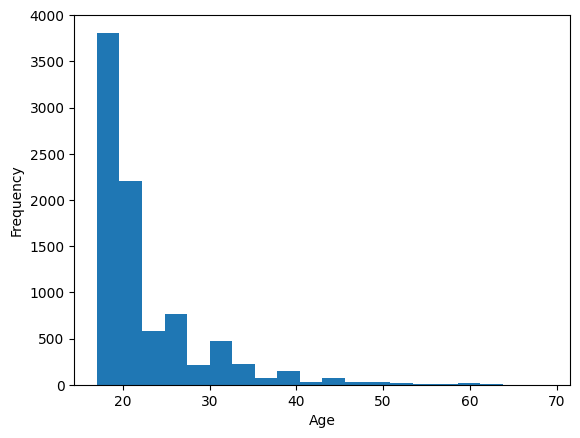

In [13]:
# Histogram of age of participants
df_adult_learner_tidy['Eng_start'].plot.hist(xlabel='Age', bins=20)
df_adult_learner_tidy['Eng_start'].describe()

Since we are interested in participants with significantly lower English proficiency than the average native English speaker, we observed the number of adult speakers who started learning English after 10 years old, do not speak English as a primary language, and have not undergone language immersion.

,age,Eng_start,yrs_learning
count,8958.000000,8958.000000,8958.000000
mean,34.517080,22.235655,12.281424
std,10.841469,6.585781,9.718739
min,18.000000,17.000000,1.000000
25%,26.000000,18.000000,5.000000
50%,33.000000,20.000000,10.000000
75%,40.000000,24.000000,17.000000
max,89.000000,69.000000,64.000000


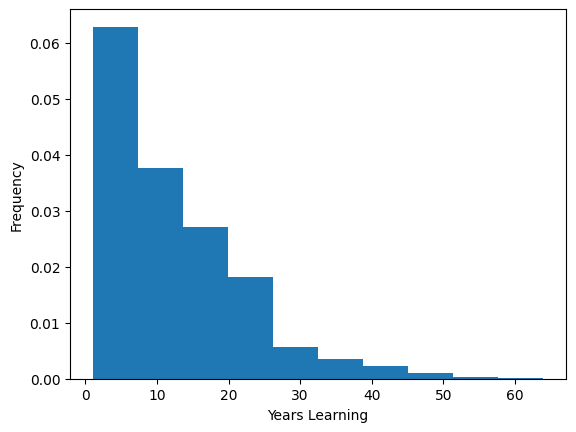

In [14]:
df_adult_learner['yrs_learning'].plot.hist(bins=10, xlabel='Years Learning', density=True)
df_adult_learner[['age', 'Eng_start', 'yrs_learning']].describe()

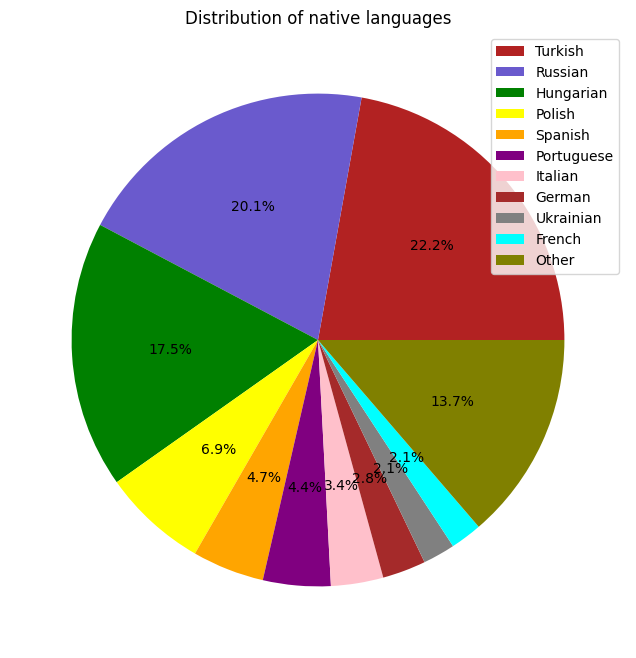

In [15]:
# Pie chart showing the percentages of non-native adult English speakers in the dataset

df_natlang_other = pd.Series(df_adult_learner_tidy['natlang'].value_counts().iloc[10:].sum(), index=['Other'])
df_natlang_pie = pd.concat([df_adult_learner_tidy['natlang'].value_counts().iloc[0:10], df_natlang_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'olive']

ax.pie(x=df_natlang_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
plt.legend(df_natlang_pie.index, loc='best')
plt.title('Distribution of native languages')
plt.show()

# Features dataset

We also parsed the following dataset from the World Atlas of Language Structures Online (WALS) webpage, which has a number of datasets on structural features of various languages. The questions in the English proficiency test from the first dataset were not explicitly testing specific elements of syntactic knowledge, so we selected 30 grammatical features that seemed relevant to the test questions.

Using these features, we hoped to create rough groupings of languages based on structural similarity rather than geographic similarity and assess each grouping's performance on the test questions.

### **ETL**

In [16]:
import glob

# Change to folder containing all additional CSVs:
%cd /content/drive/MyDrive/ColabNotebooks/additionalFiles

# Glob all csv files:
all_csvs = glob.glob('*.csv')

# Create base df for later merging:
df_features = pd.read_csv('genitive_noun.csv',sep='\t').drop(columns = ['description','value'])

# Iterate through list and merge dfs:
for file in all_csvs:
  # Read in current file and slice for non-redundant columns:
  df_current = pd.read_csv(file, sep='\t', on_bad_lines='skip')
  current_name = file[:-4] # Get name of file for df columns

  # Rename value and description columns
  df_current = df_current.rename(
      columns={
          "value": current_name + "_value",
          "description": current_name + "_description",
      }
  )

  # Select only the columns to merge
  df_current= df_current[['name', current_name + '_value', current_name + '_description']]

  # Perform the merge
  df_features = df_features.merge(df_current, on='name', how='outer')

# Drop unnecessary variables
df_features = df_features.drop(columns=['wals code', 'latitude', 'longitude', 'area'], errors='ignore') #ignore if column doesn't exist

/content/drive/MyDrive/ColabNotebooks/additionalFiles


We then checked for feature-based differences between Mandarin and Cantonese, aiming to simplify them into "Chinese," like in our first dataset. Since the two **languages/dialects** are fairly similar, we combined them.
We also renamed a few inconsistencies.

In [17]:
# Check for differences between Mandarin and Cantonese
mandarin = df_features[df_features['name'] == 'Mandarin'].reset_index(drop=True)
cantonese = df_features[df_features['name'] == 'Cantonese'].reset_index(drop=True)
display(mandarin.compare(cantonese))

# Combine Mandarin and Cantonese into a single observation, Chinese
df_features.loc[df_features['name'] == 'Mandarin', 'name'] = 'Chinese'
df_features.loc[df_features['name'] == 'Cantonese', 'name'] = 'Chinese'
df_features = df_features.groupby('name').first().reset_index()

# Rename other languages with inconsistent names between datasets
df_features['name'] = df_features['name'].str.replace(r'^Malay.*', 'Malay', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Greek.*', 'Greek', regex=True)
df_features['name'] = df_features['name'].str.replace(r'^Serbian.*', 'Serbian', regex=True)

name            indef_art_value       indef_art_description  \
       self      other            self other                  self   
0  Mandarin  Cantonese             NaN   2.0                   NaN   

                                 case_num_value        \
                           other           self other   
0  Indefinite word same as 'one'            1.0   NaN   

            case_num_description        ... passive_construction_description  \
                            self other  ...                             self   
0  No morphological case-marking   NaN  ...                          Present   

        polar_question_particles_value        \
  other                           self other   
0   NaN                            2.0   NaN   

  polar_question_particles_description       indefinite_pronouns_value        \
                                  self other                      self other   
0                                Final   NaN                       4.0   3.0   

  indefinite_pronouns_description           
                             self    other  
0                           Mixed  Special  

[1 rows x 62 columns]

Because in the WALS dataset (and not the original dataset), Arabic is broken up by regional dialect, and each dialect is significantly different grammatically, we unfortunately have to drop it:

In [18]:
df_features.drop(df_features[df_features['name'] == 'Arabic'].index, inplace=True)
df_adult_learner_tidy.drop(df_adult_learner_tidy[df_adult_learner_tidy['natlang'] == 'Arabic'].index, inplace=True)

We then merge the new DataFrame with the DataFrame from the previous milestone:

In [19]:
# Merge df_features with df_adult_learner on natlang
df_features = df_features.rename(columns={'name':'natlang'})
df_adult_learner_tidy = df_adult_learner_tidy.merge(df_features, how='left', on='natlang')

### **EDA**

We were interested in the distribution of language families in the dataset:

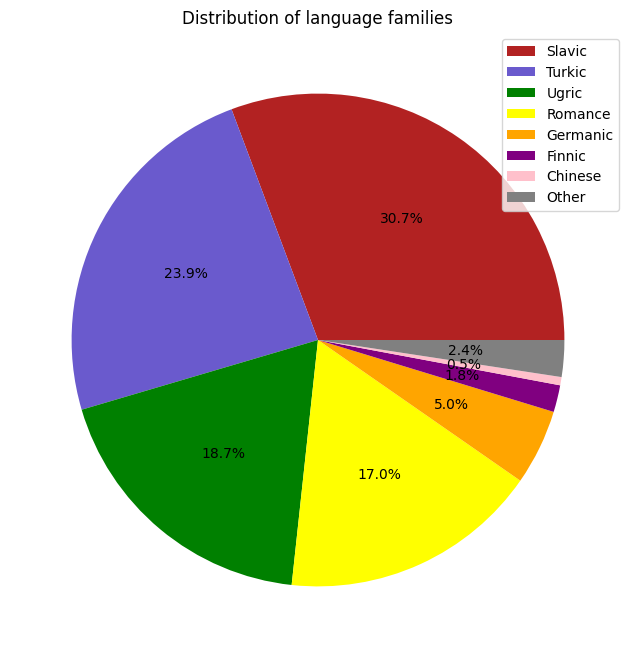

In [20]:
df_genus_other = pd.Series(df_adult_learner_tidy['genus'].value_counts().iloc[7:].sum(), index=['Other'])
df_genus_pie = pd.concat([df_adult_learner_tidy['genus'].value_counts().iloc[0:7], df_genus_other])

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['firebrick', 'slateblue', 'green', 'yellow', 'orange', 'purple', 'pink', 'gray']

ax.pie(x=df_genus_pie.values, labels=None, colors=colors, autopct='%1.1f%%')
ax.set_title('Distribution of language families')
plt.legend(df_genus_pie.index, loc='best')
plt.show()

What are the distributions of particular languages within each language family represented here?

In [21]:
df_adult_learner_tidy.groupby('genus')['natlang'].value_counts().sort_values(ascending=False)

genus                       natlang   
Turkic                      Turkish       1930
Slavic                      Russian       1750
Ugric                       Hungarian     1526
Slavic                      Polish         600
Romance                     Spanish        411
                            Portuguese     386
                            Italian        299
Germanic                    German         248
Romance                     French         181
Finnic                      Finnish         91
Romance                     Romanian        88
Slavic                      Czech           82
Germanic                    English         72
Finnic                      Estonian        53
Germanic                    Dutch           47
Chinese                     Chinese         44
Slavic                      Bulgarian       34
                            Serbian         33
Greek                       Greek           25
Vietic                      Vietnamese      24
Germanic                    Swedish         24
Romance                     Catalan         23
Baltic                      Lithuanian      22
Japanese                    Japanese        20
Korean                      Korean          15
Baltic                      Latvian         14
Kartvelian                  Georgian        13
Malayo-Sumbawan             Indonesian      13
Turkic                      Tatar            8
Germanic                    Norwegian        7
Indic                       Hindi            7
Albanian                    Albanian         6
Kam-Tai                     Thai             5
Turkic                      Turkmen          5
Dravidian                   Tamil            4
Germanic                    Icelandic        3
Indic                       Urdu             3
Slavic                      Macedonian       3
Germanic                    Danish           3
Basque                      Basque           3
Ainu                        Ainu             2
Wolof                       Wolof            2
Northwest Caucasian         Abkhaz           2
Khmer                       Khmer            2
Greater Central Philippine  Tagalog          2
Dravidian                   Telugu           2
Bantu                       Swahili          2
Nakh                        Chechen          1
Lowland East Cushitic       Somali           1
Indic                       Marathi          1
Southern Iroquoian          Cherokee         1
Dravidian                   Kannada          1
Celtic                      Irish            1
Turkic                      Uzbek            1
Athapaskan                  Navajo           1
Kam-Tai                     Lao              1
Name: count, dtype: int64

We then computed a distance matrix to determine which languages were grammatically closest to English based on these features.

In [22]:
# Add English speakers back to the dataframe, creating the dataframe for our sample

df_lang_eng = df_lang[df_lang['natlangs'] == 'English']
df_lang_eng = df_lang_eng.rename(columns={'natlangs':'natlang'})
df_lang_sample = df_adult_learner_tidy.merge(df_lang_eng, how='outer')

In [23]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# For visualization, filter by the top 30 most common languages in the dataset
df_lang_30_index = df_lang_sample['natlang'].value_counts()[:30].index
df_features = df_features[df_features['natlang'].isin(df_lang_30_index)]

# Dummify feature variables
df_features_desc = df_features.filter(regex='_description$')
df_features_encode = pd.get_dummies(df_features_desc)

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_features_imputed = imputer.fit_transform(df_features_encode)

# Convert imputed array back to DataFrame
df_features_desc = pd.DataFrame(df_features_imputed, columns=df_features_encode.columns, index=df_features_desc.index)

# Standardize data
scaler = StandardScaler()
scaler.fit(df_features_encode)
df_features_sc = scaler.transform(df_features_encode)

# Create the distance matrix
D = pairwise_distances(df_features_encode, metric='euclidean')
np.fill_diagonal(D, np.nan)
df_features_sc = pd.DataFrame(D, index=df_features['natlang'], columns=df_features['natlang'])
display(df_features_sc)

natlang,Bulgarian,Catalan,Chinese,Czech,Dutch,English,Estonian,Finnish,French,German,...,Portuguese,Romanian,Russian,Serbian,Slovak,Spanish,Swedish,Turkish,Ukrainian,Vietnamese
natlang,,,,,,,,,,,,,,,,,,,,,
Bulgarian,NaN,4.795832,5.830952,4.795832,4.898979,5.099020,4.690416,5.567764,5.099020,5.567764,...,4.000000,4.690416,4.898979,4.795832,4.690416,5.196152,4.898979,6.403124,4.123106,5.656854
Catalan,4.795832,NaN,5.916080,4.472136,4.358899,5.567764,4.795832,6.000000,5.196152,5.291503,...,4.123106,3.872983,5.385165,4.472136,4.123106,4.690416,4.123106,6.164414,4.472136,5.567764
Chinese,5.830952,5.916080,NaN,6.557439,6.000000,6.782330,6.164414,6.244998,6.782330,7.000000,...,5.830952,6.480741,6.782330,6.244998,5.830952,6.244998,6.000000,6.708204,6.082763,5.656854
Czech,4.795832,4.472136,6.557439,NaN,4.582576,5.567764,3.872983,5.656854,6.244998,5.656854,...,5.000000,5.000000,5.385165,4.000000,3.605551,5.477226,4.795832,6.324555,3.464102,6.244998
Dutch,4.898979,4.358899,6.000000,4.582576,NaN,4.690416,5.099020,6.082763,5.477226,4.795832,...,4.472136,5.099020,5.830952,5.196152,4.472136,4.358899,4.472136,6.855655,4.795832,5.830952
English,5.099020,5.567764,6.782330,5.567764,4.690416,NaN,6.000000,6.244998,5.656854,4.358899,...,5.291503,5.477226,5.830952,6.082763,5.830952,5.567764,4.690416,7.280110,5.744563,6.782330
Estonian,4.690416,4.795832,6.164414,3.872983,5.099020,6.000000,NaN,5.000000,6.000000,5.916080,...,4.690416,4.898979,5.477226,3.872983,4.000000,5.916080,4.898979,5.916080,3.000000,6.324555
Finnish,5.567764,6.000000,6.244998,5.656854,6.082763,6.244998,5.000000,NaN,6.244998,5.830952,...,5.916080,6.082763,5.567764,5.656854,5.744563,5.656854,5.744563,6.324555,5.477226,6.403124
French,5.099020,5.196152,6.782330,6.244998,5.477226,5.656854,6.000000,6.244998,NaN,5.000000,...,4.690416,5.477226,5.291503,6.082763,6.000000,4.358899,5.656854,6.244998,5.567764,6.782330


Since the distance matrix is hard to read, we created a heatmap to visualize our data.

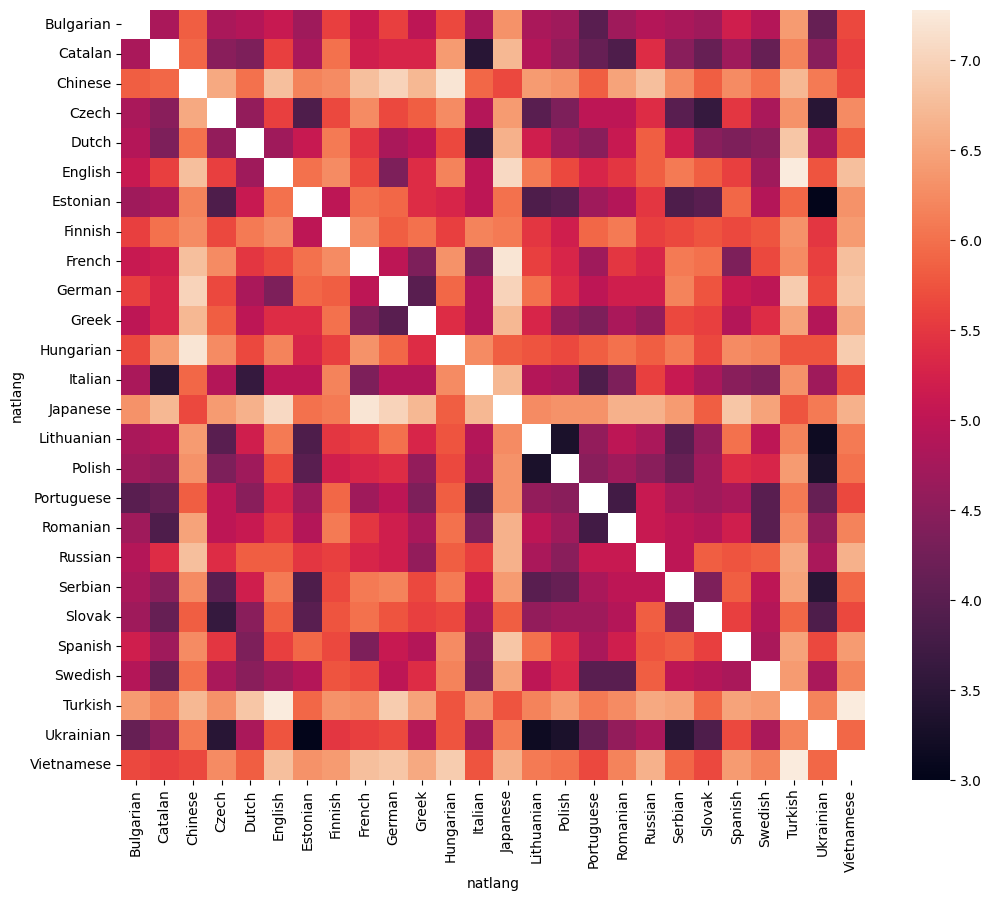

In [24]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_features_sc)
sns.set(font_scale=1.2)

We then observed each language's distance from English based on the syntactic features. There were some surprising languages due to the relatively small number of features included, but the distances lined up with our intuitions overall.

In [25]:
# Slice DataFrame for distances from English
df_eng_dist = df_features_sc['English'].sort_values()
display(df_eng_dist)

,English
natlang,
German,4.358899
Swedish,4.690416
Dutch,4.690416
Italian,5.000000
Bulgarian,5.099020
Portuguese,5.291503
Greek,5.385165
Romanian,5.477226
Spanish,5.567764


Is there a relationship between syntactic similarity to English and overall test performance among adult non-Native English speakers?

,Distance,correct
Distance,1.000000,-0.435539
correct,-0.435539,1.000000


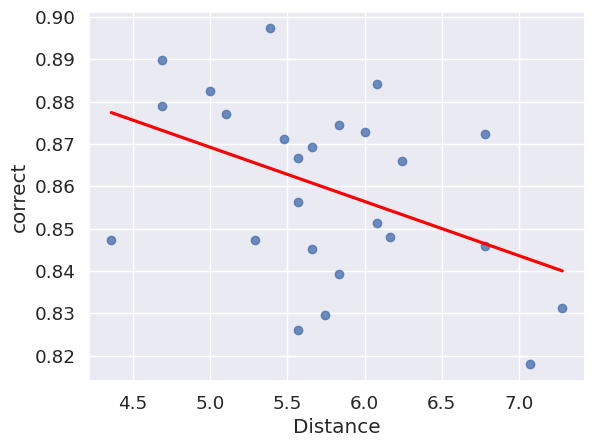

In [26]:
df_lang_30 = df_lang_sample[df_lang_sample['natlang'].isin(df_lang_30_index)]
df_30_correct = df_lang_30.groupby('natlang')['correct'].mean().sort_values(ascending=False)

# Organize alphabetically to have the same index
df_eng_dist = df_eng_dist.sort_index()
df_30_correct = df_30_correct.sort_index()

# Concatenate the two Series and sort
df_eng_dist_concat = pd.DataFrame(df_eng_dist).merge(df_30_correct,how='left',on='natlang')
df_eng_dist_concat = df_eng_dist_concat.rename(columns={'English': 'Distance'})
df_eng_dist_concat = df_eng_dist_concat.sort_values(by = 'Distance')
df_eng_dist_concat = df_eng_dist_concat.drop('English')

# Create plot
sns.regplot(x='Distance', y='correct', data=df_eng_dist_concat, ci=None, line_kws={'color': 'red'})
df_eng_dist_concat.corr()

There is only a weak negative relationship between syntactic similarity to English and overall test performance (r=-0.67).


While there are clearly some languages that are more similar than others, as visible on the distance matrix, we decided to use K means clustering to be more certain of the groups of languages. We experimented with several different numbers of clusters, but decided on 7.

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

# Fit the model to the data
df_eng_dist_concat = df_eng_dist_concat.fillna(0)
kmeans.fit(df_eng_dist_concat)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the labels to the dataframe
df_eng_dist_concat['cluster'] = labels
df_eng_dist_concat.sort_values(by='cluster')

,Distance,correct,cluster
natlang,,,
French,5.656854,0.869148,0
Ukrainian,5.744563,0.829519,0
Bulgarian,5.099020,0.877090,0
Portuguese,5.291503,0.847178,0
Greek,5.385165,0.897263,0
Romanian,5.477226,0.871172,0
Spanish,5.567764,0.856192,0
Czech,5.567764,0.866752,0
Catalan,5.567764,0.826087,0


In [28]:
# Merge df_PCA with df_lang_sample
df_lang_sample = df_lang_sample.merge(df_eng_dist_concat.drop(columns='correct'), how='left', on='natlang')


To better visualize each language's distance from English, as well as how close they are to other languages, we used principle component analysis (PCA) to reduce the number of dimensions to 2.

<Figure size 1000x800 with 0 Axes>

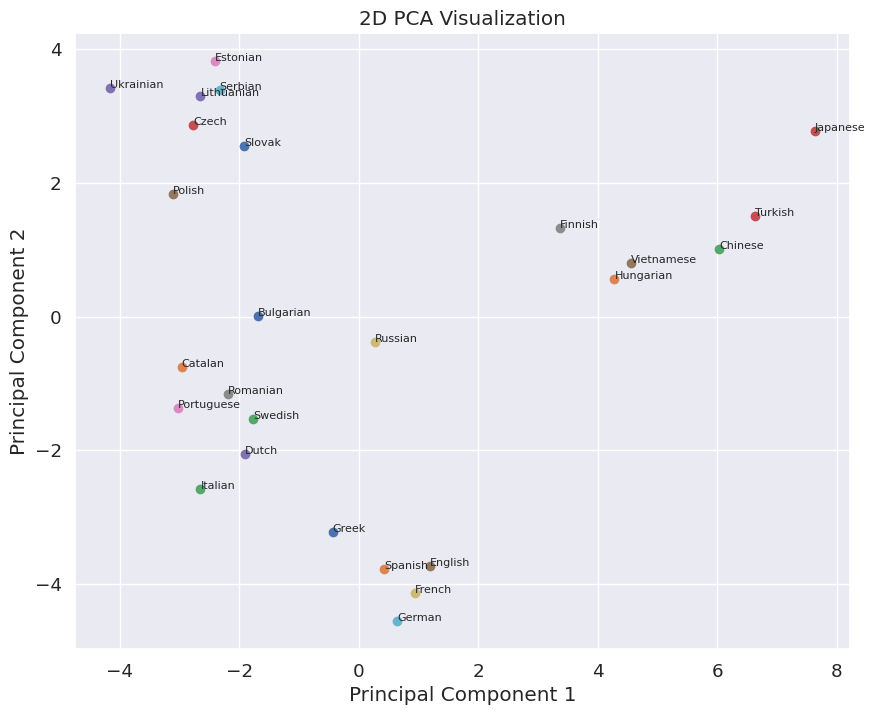

In [29]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 8))

pca = PCA(n_components=2)

# Fit the PCA model to the scaled data
df_features_sc = df_features_sc.fillna(0)
principal_components = pca.fit_transform(df_features_sc)

# Create a DataFrame with the principal components
df_PCA = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot results
plt.figure(figsize=(10, 8))  # Adjust figure size if needed

# Scatter plot with labels
for i, language in enumerate(df_features['natlang']):
    x = df_PCA.loc[i, 'PC1']
    y = df_PCA.loc[i, 'PC2']
    plt.scatter(x, y)
    plt.text(x, y, language, fontsize=8)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

Overall, the groups visible on the PCA plot are similar to the groups given previously by the K means clustering algorithm. Somewhat remarkably, languages that are geographically and linguistically close to each other in real life are also close to each other on this plot, which only uses 30 grammatical features -- you can make out the Slavic language group and something of the Germanic and Austronesian language groups.

In the subsequent analysis, we will use the clusters in the unreduced dimensional space for better interpretability. At first glance, we only saw slight differences in performance by cluster:

In [32]:
# How many people are in each cluster?
cluster_counts = df_lang_sample['cluster'].value_counts()
display(cluster_counts)

# Make each cluster size roughly equal
df_lang_sample = df_lang_sample.drop(df_lang_sample[df_lang_sample['natlang']=='English'].index)

df_lang_sample = df_lang_sample.drop(df_lang_sample[df_lang_sample['cluster'] == 0].sample(frac=((3511-618)/3511), random_state=1).index)
df_lang_sample = df_lang_sample.drop(df_lang_sample[df_lang_sample['cluster'] == 2].sample(frac=((2018-618)/2018), random_state=1).index)
df_lang_sample = df_lang_sample.drop(df_lang_sample[df_lang_sample['cluster'] == 3].sample(frac=((2014-618)/2014), random_state=1).index)

,count
cluster,
3.0,3511
1.0,2018
0.0,2014
2.0,618


,correct
cluster,
0.0,0.853195
1.0,0.831949
2.0,0.864996
3.0,0.846494


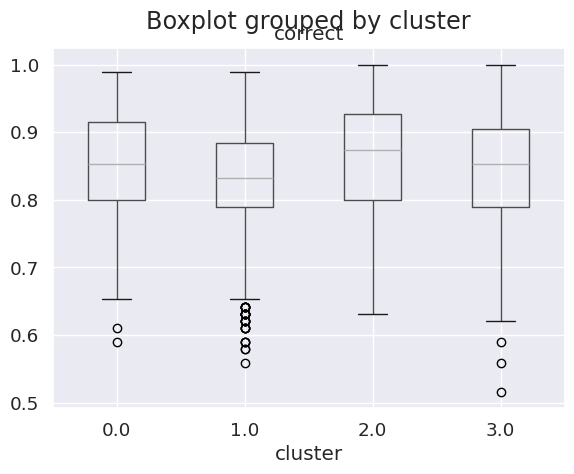

In [33]:
# Create boxplots
df_lang_sample.boxplot(column='correct', by='cluster')

# Compare mean scores
df_lang_sample.groupby('cluster')['correct'].mean()

To statistically test for significant differences in the overall performance of the  clusters, we performed a one-way ANOVA and a post-hoc Tukey's test. The only group differences that we failed to reject were between clusters 0 and 4, 3 and 6, and 5 and 6.

In [34]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

# ANOVA
model = sm.ols(formula='correct ~ C(cluster)', data=df_lang_sample).fit()
anova_table = anova_lm(model, typ=2)
anova_table

# Post hoc tests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df_lang_sample['correct'], df_lang_sample['cluster'])
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0  -0.0212    0.0 -0.0334 -0.0091   True
   0.0    2.0   0.0118 0.4349 -0.0072  0.0308  False
   0.0    3.0  -0.0067 0.6153 -0.0196  0.0062  False
   0.0    nan  -0.0264    0.0 -0.0415 -0.0112   True
   1.0    2.0    0.033    0.0   0.017  0.0491   True
   1.0    3.0   0.0145    0.0  0.0066  0.0225   True
   1.0    nan  -0.0051 0.7241 -0.0164  0.0061  False
   2.0    3.0  -0.0185 0.0201 -0.0351 -0.0019   True
   2.0    nan  -0.0382    0.0 -0.0566 -0.0198   True
   3.0    nan  -0.0197 0.0001 -0.0318 -0.0076   True
----------------------------------------------------


However, this analysis overlooks whether there are significant differences between clusters in performance on each question. As the graph below shows, there appear to be substantial differences in the performance of each cluster on some test questions:

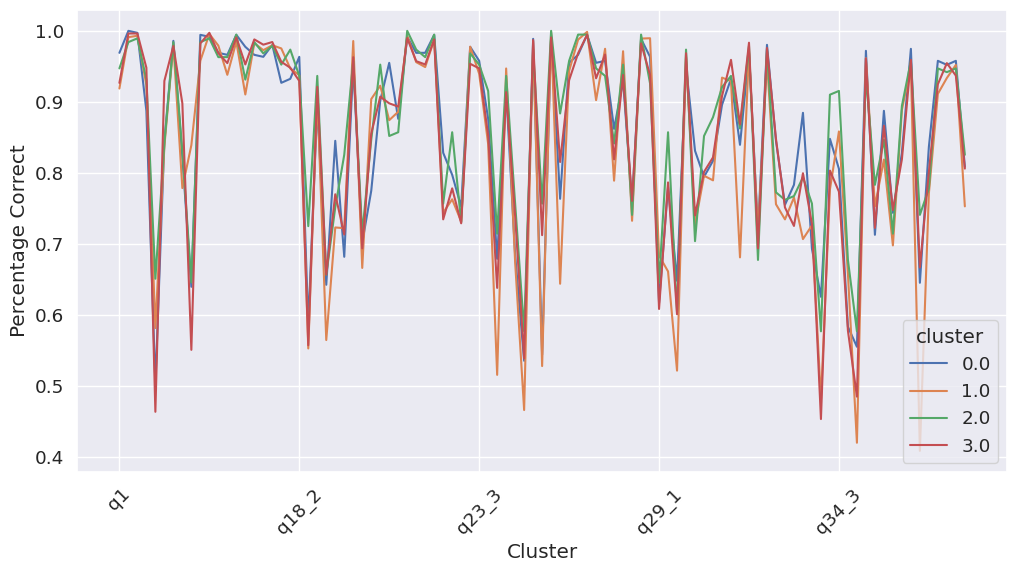

In [35]:
# Create index of each question column
question_index = df_lang_sample.columns[pd.Series(df_lang_sample.columns).str.startswith('q')]

# Create empty list
df_questions = pd.DataFrame()

# Iterate through questions to find correct % for each question based on clusters
for question in question_index:
  clust = df_lang_sample.groupby('cluster')[question].mean()
  df_questions = pd.concat([df_questions, clust],axis=1)

df_questions = df_questions.reset_index()
df_questions = df_questions.rename(columns={'index': 'cluster'})
df_questions = df_questions.melt(id_vars=['cluster'])

# Create barplot comparing scores of different clusters on questions
fig, ax = plt.subplots(figsize=(12, 6))
df_questions_pivot = df_questions.pivot_table(index='variable', columns='cluster', values='value')
df_questions_pivot.plot(kind='line', ax=ax)
plt.xlabel('Cluster')
plt.ylabel('Percentage Correct')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

We performed another ANOVA to officially test for differences in test question performance among groups.

In [36]:
model = sm.ols(formula='value ~ C(cluster)', data=df_questions).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(cluster),0.054185,3.0,0.93941,0.421619
Residual,7.229246,376.0,NaN,NaN


This table shows that there are significant differences in the performance on specific test questions.

# **Modeling**

We than aimed to create a *k*-nearest neighbors classifier to predict a given participant's language cluster based on their answers to the test questions.

In [37]:
from sklearn.neighbors import KNeighborsClassifier

df_model = pd.concat([df_lang_sample[['cluster','natlang']],df_lang_sample[question_cols]],axis=1)

df_model = df_model.dropna()

# Split data into training and validation sets
x_train = df_model.drop(columns=['cluster','natlang']).sample(frac=.5, random_state=1)
y_train = df_model['cluster'].sample(frac=.5, random_state=1).dropna()

x_test = df_model.drop(columns=['cluster','natlang']).drop(x_train.index)
y_test = df_model['cluster'].drop(x_train.index)

# Standardize the data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

def knnclass(k):
  # Fit the k-nearest neighbors model
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(x_train_sc, y_train)

  #predict the training data
  y_train_pred = model.predict(x_train_sc)

  #predict the validation data
  y_test_pred = model.predict(x_test_sc)

  confusion_mat = pd.crosstab(y_test, y_test_pred)
  confusion_mat = confusion_mat.reindex(columns=range(0,4)) #ensures that the confusion matrix has the correct dimensions
  confusion_mat = confusion_mat.fillna(0) # replace NaNs from line above

  accuracy = np.diag(confusion_mat).sum() / confusion_mat.to_numpy().sum()

  return accuracy

# Test the model for varying values of k
ks = range(1,100)
accuracies = [knnclass(k) for k in ks]


,0
36,0.632216
26,0.629467
80,0.628917
33,0.627817
35,0.627817
...,...
4,0.561847
3,0.561297
2,0.529962
1,0.501374


Text(0, 0.5, 'Accuracy')

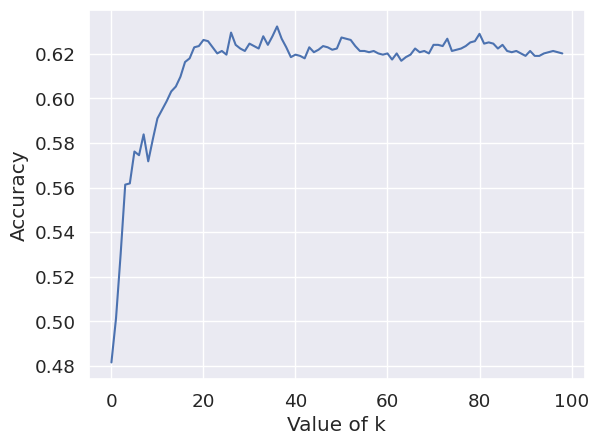

In [38]:
knn_vals = pd.Series(accuracies).sort_values(ascending=False)

display(knn_vals)
plt.plot(accuracies)
plt.xlabel('Value of k')
plt.ylabel('Accuracy')

<Axes: xlabel='Predicted Cluster', ylabel='Actual Cluster'>

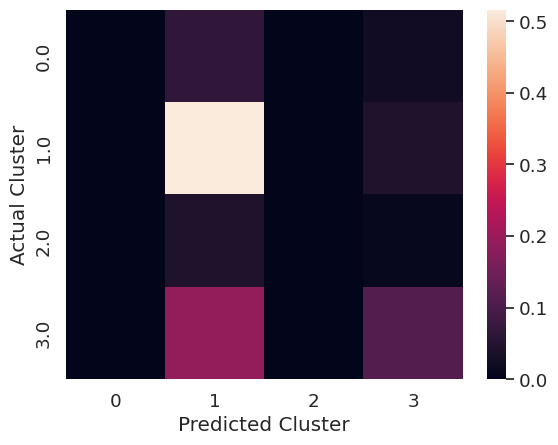

In [41]:
# Fit the 36-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=36)
model.fit(x_train_sc, y_train)

#predict the training data
y_train_pred = model.predict(x_train_sc)

#predict the validation data
y_test_pred = model.predict(x_test_sc)

confusion_mat = pd.crosstab(y_test, y_test_pred)
confusion_mat = confusion_mat.reindex(columns=range(0,4))
confusion_mat = confusion_mat.fillna(0)
confusion_mat = confusion_mat / confusion_mat.sum().sum()

confusion_mat = confusion_mat.rename_axis('Predicted Cluster', axis='columns')
confusion_mat = confusion_mat.rename_axis('Actual Cluster', axis='rows')

sns.heatmap(confusion_mat)

In [48]:
true_pos = np.diag(confusion_mat).sum()
false_pos = (confusion_mat.sum(axis=0) - np.diag(confusion_mat))
false_neg = (confusion_mat.sum(axis=1) - np.diag(confusion_mat))

precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
f_score = precision * recall / (precision + recall)

precision = precision.rename('Precision').rename_axis(index=None)
recall = recall.rename('Recall').rename_axis(index=None)
f_score = f_score.rename('F-Score').rename_axis(index=None)

pd.concat([precision,recall,f_score],axis=1).rename_axis(index='Cluster')

,Precision,Recall,F-Score
Cluster,,,
0.0,0.998252,0.877112,0.466885
1.0,0.678954,0.936833,0.393657
2.0,1.000000,0.924696,0.480438
3.0,0.894283,0.766958,0.412871
